# Rankify
## Análisis de una red egocéntrica de segundo grado creada por una playlist de Spotify haciendo uso del algoritmo de PageRank
### Trabajo Grupal grupo 7

a) Estudiar medidas de centralidad y/o comunidades (u otros parámetros de interés)
en un grafo contextualizado como una red de mundo pequeño. El ejemplo no tiene
por qué ser real, pero tiene que reflejar el comportamiento de una red correctamente.
Para ello, utilizar un artículo matemático que estudie el método utilizado o aplique
algún método al tipo de red utilizado. 

Se ha usado como referencia: 

P. Mohan, P. Narayan and L. Sharma, "Egocentric Analysis of GitHub User Network," 2021 2nd International Conference for Emerging Technology (INCET), Belagavi, India, 2021, pp. 1-7, doi: 10.1109/INCET51464.2021.9456183. keywords: {Productivity;Social networking (online);Entertainment industry;Clustering algorithms;Tools;Approximation algorithms;Security;PageRank algorithm;GitHub API;Egocentric analysis;Ego network;Clustering coefficient;Cluster density;Alters},



* Se usará la librería spotipy para las llamadas a la API de Spotify, la instalamos

In [1]:
!pip install spotipy

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

* Usamos una ClientID y ClientSecret dados al crear una aplicación en Spotify
* Se obtienen de developer.spotify.com/dashboard (Creo que hace falta Premium)
<div class="alert alert-danger">
    <h1><strong>¡¡¡¡¡¡¡¡¡BORRAR ANTES DE ENVIAR O PUBLICAR!!!!!!!!!!!!</strong> </h1>
</div>

In [3]:
client_id = ""
client_secret = ""

## Obtención de datos de la Playlist

In [4]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

* Creamos una función para tener los artistas y nombre de una playlist.
* Necesitamos devolver también el ID de cada artista para poder analizar cada uno después

In [5]:
def obtener_playlist_con_ids(playlist_url):
    '''
    Obitiene los artistas y nombre de una playlist pasada por parámetro
    @param: playlist_url URL de la playlist de la que obtener los datos
    @returns: nombre_playlist String del nombre que tiene la playlist
    @returns: artistas_map diccionario(nombre:id) de cada artista de la playlist
    '''
    # Obtener datos básicos por API
    print("Conectando con la API de Spotify...")
    playlist_data = sp.playlist(playlist_url)
    nombre_playlist = playlist_data['name']
    
    # Paginación
    results = playlist_data['tracks']
    tracks = results['items']
    while results['next']: # La API devuelve los temas de 100 en 100 luego pueden ser necesarias múltiples llamadas
        results = sp.next(results)
        tracks.extend(results['items'])
    print(f"Encontrados {len(tracks)} temas en la playlist {nombre_playlist}")
        
    # Extraer Nombres e IDs {nombre:id}
    artistas_map = {} 
    
    for item in tracks:
        if item is not None and item.get('track') is not None:
            track = item['track']
            for artist in track['artists']: # Por cada artista en una canción
                artistas_map[artist['name']] = artist['id']
    print(f"Encontrados {len(artistas_map.keys())} artistas distintos")
                
    return nombre_playlist, artistas_map

* Llamar a la función.
<div class="alert alert-info" role="alert" style="display: flex; align-items: center;">
    <i class="fa fa-info-circle fa-3x" style="margin-right: 20px;"></i>
    <div>
        <h1 style="margin: 0;"><strong>Aquí se cambia la URL</strong></h1>
    </div>
</div>

In [6]:
# Aquí va tu playlist:
url_playlist = "https://open.spotify.com/playlist/3Xq1TpD6bXiLeg7rjGVw2x?si=b954e673863d41e0"

# Llamada para consultar datos de la Playlist
nombre_playlist, mapa_artistas_originales = obtener_playlist_con_ids(url_playlist)

print(f"Playlist: {nombre_playlist}")
print(f"Artistas originales encontrados: {len(mapa_artistas_originales)}")

Conectando con la API de Spotify...
Encontrados 43 temas en la playlist Love, Hate & anything in between
Encontrados 43 artistas distintos
Playlist: Love, Hate & anything in between
Artistas originales encontrados: 43


## Creación del grafo
* Ahora necesitamos una función que utilice estos datos para generar el grafo con el que trabajaremos
* Esta función genera un grafo egocéntrico de segundo grado (Nomenclatura de la referencia).
* Para ello genera un grafo estrella con centro el nombre de la playlist y un extremo por cada artista en esta y luego une este artista con los artistas con los que ha colaborado en sus 10 canciones más populares.(Red egocéntrica de primer grado)
* Devuelve también otros datos de interés para la representación del grafo tales como qué tipo de arista representa cada una(Futura coloración distinta a aristas de primer, segundo y grado y medio)

In [7]:
def crear_red_egocentrica(nombre_playlist, mapa_artistas, verbosity=1):
    """
    Genera un grafo egocéntrico expandido.
    Para ello genera un grafo estrella con centro el nombre de la playlist
    y un extremo por cada artista en esta y luego une este artista con los
    artistas con los que ha colaborado en sus 10 canciones más populares.
    
    @returns: Graph, Dicho grafo
    @returns: 3 lists¬
                     └► aristas_estrella (Aristas de la estrella original)
                        aristas_internas (Colaboraciones entre artistas ya presentes en la estrella)
                        aristas_externas (Colaboraciones con nuevos artistas)
    
    @param: nombre_playlist String, nombre de la playlist
    @param: mapa_artistas {nombre_artista:id_artista}, Diccionario con los artistas de la playlist
    @param: verbosity Integer¬
                             └► 0 = Silencioso. 
                                1 (Default) = Progreso general (Barra de carga). 
                                2 = Detallado (Traza de API y conexiones individuales).
    """
    G = Graph()
    
    # Listas para guardar los diferentes tipos de aristas
    aristas_estrella = []
    aristas_internas = []
    aristas_externas = []
    
    # Inicio para verbosities mayores a 0
    nombres_originales = set(mapa_artistas.keys())
    total_artistas = len(mapa_artistas)
    
    if verbosity > 0:
        print(f"--- INICIO DEL PROCESO ---")
        print(f"Objetivo: Expandir red de '{nombre_playlist}'")
        print(f"Nodos semilla: {total_artistas} artistas.")
        print("-" * 30)

    # Aristas Estrella (Playlist -> Artista)
    if verbosity >= 2:
        print(f"Creando conexiones base (Estrella)...")
        
    for artista_nombre in mapa_artistas.keys():
        aristas_estrella.append((nombre_playlist, artista_nombre))
    
    G.add_edges(aristas_estrella)
    
    if verbosity >= 2:
        print(f"   -> {len(aristas_estrella)} conexiones base creadas.")

    # Buscar Colaboraciones (Top Tracks)
    if verbosity > 0:
        print(f"Consultando API de Spotify para colaboraciones...")
        
    count = 0
    nuevos_nodos_encontrados = 0
    
    # Procesado de cada artista
    for origen_nombre, origen_id in mapa_artistas.items():
        try:
            # LOG DETALLADO (Nivel 2)
            if verbosity >= 2:
                print(f"   > [API Call] Solicitando Top Tracks de: '{origen_nombre}'...")
            
            # Llamada a la API
            top_tracks = sp.artist_top_tracks(origen_id, country='ES') # Tomar los temás más populares en España(def. 10)
            tracks_list = top_tracks['tracks']
            
            if verbosity >= 2:
                 print(f"     Recibidos {len(tracks_list)} tracks. Analizando...")
            
            # Procesado de los top tracks del artista
            for track in tracks_list:
                artistas_en_track = track['artists']
                
                # Si hay más de 1 artista, hay colaboración
                if len(artistas_en_track) > 1:
                    for artista_colab in artistas_en_track:
                        colab_nombre = artista_colab['name']
                        
                        # Evitar bucles propios
                        if colab_nombre == origen_nombre:
                            continue
                        
                        nueva_arista = (origen_nombre, colab_nombre)
                        
                        # CLASIFICACIÓN DE ARISTA
                        if colab_nombre in nombres_originales:
                            # Colaboración INTERNA
                            if not G.has_edge(nueva_arista):
                                aristas_internas.append(nueva_arista)
                                if verbosity >= 2:
                                    print(f"       [+] Conexión INTERNA: {origen_nombre} <-> {colab_nombre}")
                        else:
                            # Colaboración EXTERNA (Nodo nuevo)
                            # Verificamos si es la primera vez que vemos este nodo nuevo para el contador
                            if colab_nombre not in G.vertices():
                                nuevos_nodos_encontrados += 1
                                
                            aristas_externas.append(nueva_arista)
                            if verbosity >= 2:
                                print(f"       [*] Conexión EXTERNA: {origen_nombre} -> {colab_nombre} (Nuevo)")
                            
                        G.add_edge(nueva_arista)
            
            count += 1
            
            # LOG DE PROGRESO (Nivel 1)
            if verbosity == 1 and count % 10 == 0:
                print(f"Procesando... {count}/{total_artistas} artistas completados.")
                
        except Exception as e:
            if verbosity > 0:
                print(f"!!! ERROR con artista '{origen_nombre}': {e}")
            continue

    if verbosity > 0:
        print("-" * 30)
        print(f"--- FIN DEL PROCESO ---")
        print(f"Total Nodos Finales: {G.order()}")
        print(f"Total Aristas: {G.size()}")
        print(f"   - Internas (entre originales): {len(aristas_internas)}")
        print(f"   - Externas (nuevos descubrimientos): {len(aristas_externas)}")

    return G, aristas_estrella, aristas_internas, aristas_externas

In [8]:
# Llamada a la función
G, edges_star, edges_in, edges_out = crear_red_egocentrica(nombre_playlist, mapa_artistas_originales)

--- INICIO DEL PROCESO ---
Objetivo: Expandir red de 'Love, Hate & anything in between'
Nodos semilla: 43 artistas.
------------------------------
Consultando API de Spotify para colaboraciones...
Procesando... 10/43 artistas completados.
Procesando... 20/43 artistas completados.
Procesando... 30/43 artistas completados.
Procesando... 40/43 artistas completados.
------------------------------
--- FIN DEL PROCESO ---
Total Nodos Finales: 272
Total Aristas: 352
   - Internas (entre originales): 43
   - Externas (nuevos descubrimientos): 311


Generando gráfico con 272 nodos y 352 conexiones...


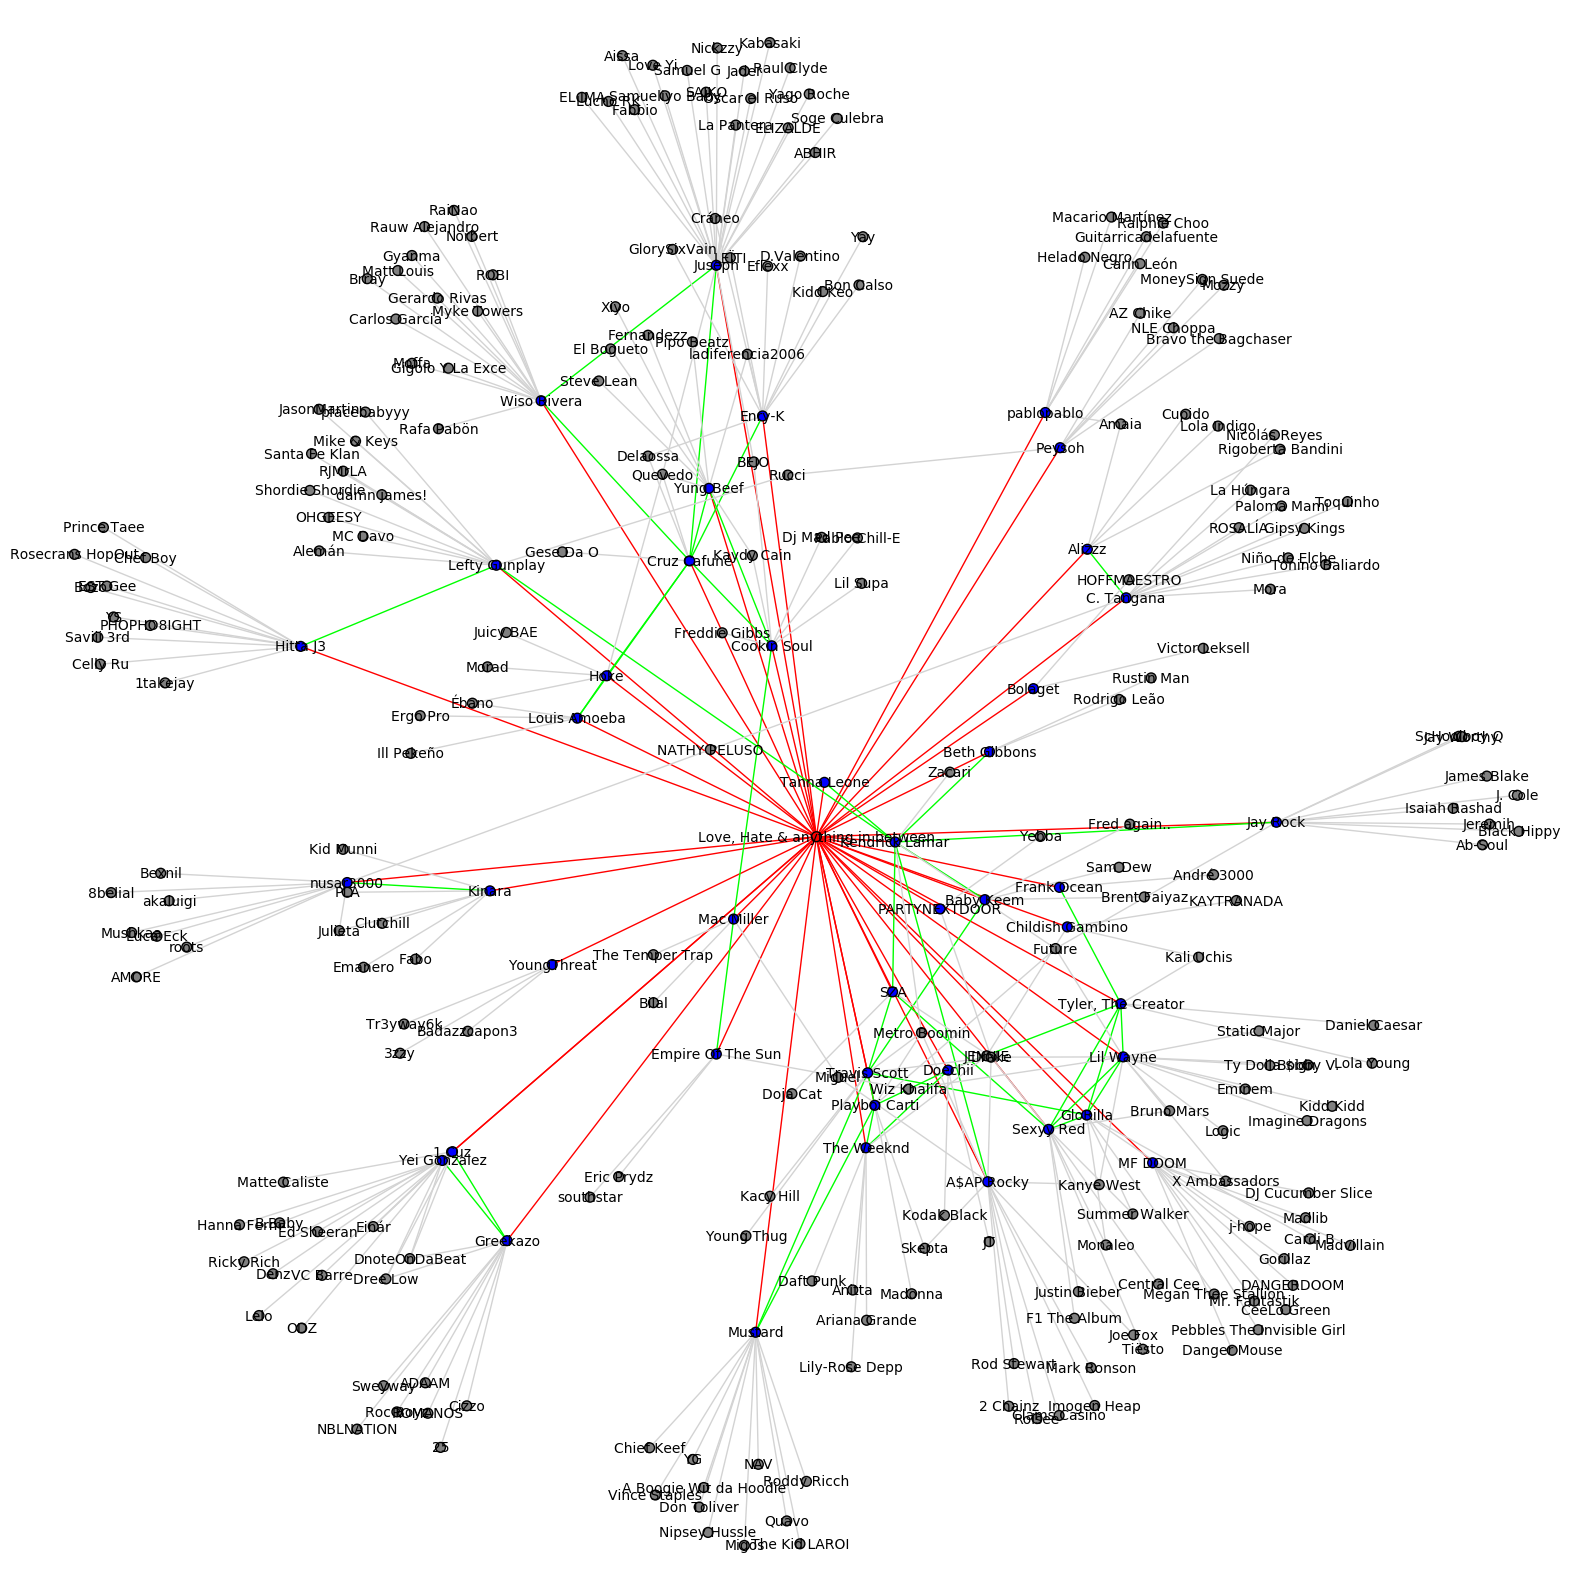

In [9]:

# Definir los colores de las aristas
colores_aristas = {
    '#ff0000': edges_star,  # ROJO: Conexión Playlist -> Artista
    '#00ff00': edges_in,    # VERDE: Colaboración interna (Artista A <-> Artista B)
    '#d3d3d3': edges_out    # GRIS CLARO: Colaboración externa (Artista A <-> Nuevo)
}

# Definir colores de nodos
# Necesitamos saber cuáles son los nodos nuevos para pintarlos diferente
todos_los_nodos = G.vertices()
nodos_playlist = [nombre_playlist]
nodos_originales = list(mapa_artistas_originales.keys())
# Los nuevos son: Todos - (Playlist + Originales)
nodos_nuevos = list(set(todos_los_nodos) - set(nodos_originales) - set(nodos_playlist))

colores_nodos = {
    'red': nodos_playlist,       # Centro rojo
    'blue': nodos_originales,    # Artistas base azul
    'gray': nodos_nuevos         # Artistas externos gris
}

print(f"Generando gráfico con {G.order()} nodos y {G.size()} conexiones...")

# 3. Plot
G.plot(
    layout='spring',           # Algoritmo de fuerzas
    iterations=50,             # Más iteraciones para desenredar
    vertex_size=50,
    vertex_labels=True,       # False para no saturar si hay muchos, True para ver nombres
    vertex_colors=colores_nodos,
    edge_colors=colores_aristas,
    figsize=[16, 16]           # Tamaño grande
).show()

* Por divesión voy a hacer una función que exporte a un formato para verlo en un lector más cómodo (Uso Gephi)

In [10]:
import networkx as nx

def exportar_grafo_para_gephi(G_sage, nombre_playlist, mapa_artistas, nombre_archivo="red_spotify.graphml", calcular_centralidad=True):
    """
    Función que cambia a grafo de tipo nx y lo exporta haciendo los mapeos necesarios
    """
    
    print(f"--- Iniciando exportación a {nombre_archivo} ---")
    
    # 1. Conversión a NetworkX
    NX_G = G_sage.networkx_graph()
    
    # 2. Calcular métricas y convertir a float nativo
    if calcular_centralidad:
        print("Calculando centralidad...")
        bb = nx.betweenness_centrality(NX_G)
        
        # Convertimos los valores de Sage a float de Python
        bb_python = {k: float(v) for k, v in bb.items()}
        
        nx.set_node_attributes(NX_G, bb_python, 'centralidad')

    # 3. Inyección de Atributos Visuales
    print("Asignando atributos...")
    count_nuevos = 0
    
    for nodo in NX_G.nodes():
        attrs = {}
        
        # Usamos float(50.0) en lugar de 50.0 directo
        
        # A. EL NODO FUENTE (PLAYLIST)
        if nodo == nombre_playlist:
            attrs = {
                'tipo': 'Playlist',
                'viz_color': '#ff0000', 
                'size': float(50.0),    # <--- Cast a float python
                'label': str(nodo)      # Aseguramos que el nombre sea string
            }
        
        # B. ARTISTAS ORIGINALES
        elif nodo in mapa_artistas:
            attrs = {
                'tipo': 'Original',
                'viz_color': '#0000ff', 
                'size': float(30.0),    # <--- Cast a float python
                'label': str(nodo)
            }
            
        # C. DESCUBRIMIENTOS
        else:
            attrs = {
                'tipo': 'Descubrimiento',
                'viz_color': '#a9a9a9', 
                'size': float(10.0),    # <--- Cast a float python
                'label': str(nodo)
            }
            count_nuevos += 1
            
        NX_G.nodes[nodo].update(attrs)

    # 4. Guardar archivo
    try:
        nx.write_graphml(NX_G, nombre_archivo)
        print(f"✅ EXPORTACIÓN EXITOSA: '{nombre_archivo}' generado.")
    except Exception as e:
        print(f"❌ Error guardando el archivo: {e}")

In [11]:
exportar_grafo_para_gephi(G, nombre_playlist, mapa_artistas_originales, "analisis_spotify_final.graphml")

--- Iniciando exportación a analisis_spotify_final.graphml ---
Calculando centralidad...
Asignando atributos...
✅ EXPORTACIÓN EXITOSA: 'analisis_spotify_final.graphml' generado.


### Pequeño bloque que rápidamente recibe una URL y lo exporta a archivo .graphml

In [12]:
# Quick URL to export

url_playlist = "https://open.spotify.com/playlist/3Xq1TpD6bXiLeg7rjGVw2x?si=a3bad36b2ea94f39"
nombre_playlist, mapa_artistas_originales = obtener_playlist_con_ids(url_playlist)
G, edges_star, edges_in, edges_out = crear_red_egocentrica(nombre_playlist, mapa_artistas_originales)
exportar_grafo_para_gephi(G, nombre_playlist, mapa_artistas_originales, "quick_spotify_graph.graphml")

Conectando con la API de Spotify...
Encontrados 43 temas en la playlist Love, Hate & anything in between
Encontrados 43 artistas distintos
--- INICIO DEL PROCESO ---
Objetivo: Expandir red de 'Love, Hate & anything in between'
Nodos semilla: 43 artistas.
------------------------------
Consultando API de Spotify para colaboraciones...
Procesando... 10/43 artistas completados.
Procesando... 20/43 artistas completados.
Procesando... 30/43 artistas completados.
Procesando... 40/43 artistas completados.
------------------------------
--- FIN DEL PROCESO ---
Total Nodos Finales: 272
Total Aristas: 352
   - Internas (entre originales): 43
   - Externas (nuevos descubrimientos): 311
--- Iniciando exportación a quick_spotify_graph.graphml ---
Calculando centralidad...
Asignando atributos...
✅ EXPORTACIÓN EXITOSA: 'quick_spotify_graph.graphml' generado.


## Aplicación de PageRank para recomendaciones
* Ahora que tenemos ya el grafo vamos a buscar cuáles de estos nodos añadidos tienen más importancia en la red, para ello vamos a aplicar PageRank al grafo
* La función tiene dos modos de uso, una que toma en cuenta todos los nodos y otro que da peso 1 a tus artistas originales y 0 a los nuevos. Esto le dice al algoritmo: "El usuario confía en ESTOS nodos" (Normalmente mejor para recomendaciones)

In [13]:
import networkx as nx

def recomendar_nuevos_artistas(G_sage, nombre_playlist, mapa_artistas_originales, usar_personalizado=True):
    """
    Calcula PageRank y filtra para mostrar solo los artistas descubiertos.
    
    @param: G_sage Grafo al que calcular PageRank, se espera de tipo Sage
    @param: nombre_playlist String nombre de la playlist
    @param: mapa_artistas_originales Diccionario de artistas devuelto en la función anterior
    @param: usar_personalizado=True Da más peso a los nodos que están conectados directamente a tu playlist.
                                    Es mejor para recomendaciones de música.
    
    @returns: ranking_nuevos Lista de tuplas (artista,score) ordenados de mayor a menor score.
        
    """
    
    # Convertir a NetworkX
    NX_G = G_sage.networkx_graph()
    
    # Lista de nodos que ya conoces (para exclurilos del top final)
    nodos_conocidos = set(mapa_artistas_originales.keys())
    nodos_conocidos.add(nombre_playlist)
    
    print(f"Calculando ranking sobre {NX_G.number_of_nodes()} nodos...")

    # CALCULAR PAGERANK
    if usar_personalizado:
        print("--- Modo: PageRank Personalizado (Enfocado en tus gustos) ---")
        # Personalization: Creamos un diccionario donde damos peso 1 a tus artistas originales
        # y 0 a los nuevos. Esto le dice al algoritmo: "El usuario confía en ESTOS nodos".
        personalizacion = {nodo: 1 if nodo in nodos_conocidos else 0 for nodo in NX_G.nodes()}
        
        scores = nx.pagerank(NX_G, alpha=0.85, personalization=personalizacion)
    else:
        print("--- Modo: PageRank Global (Popularidad general en la red) ---")
        scores = nx.pagerank(NX_G, alpha=0.85)

    # FILTRAR Y ORDENAR
    # Creamos una lista de tuplas (Artista, Score) SOLO si es nuevo
    ranking_nuevos = []
    
    for artista, score in scores.items():
        if artista not in nodos_conocidos:
            ranking_nuevos.append((artista, score))
    
    # Ordenamos de mayor a menor score
    ranking_nuevos.sort(key=lambda x: x[1], reverse=True)
    
    return ranking_nuevos

In [16]:
# Normalmente usar_personalizado=True da mejores resultados
top_descubrimientos = recomendar_nuevos_artistas(G, nombre_playlist, mapa_artistas_originales, usar_personalizado=True)
#top_descubrimientos = recomendar_nuevos_artistas(G, nombre_playlist, mapa_artistas_originales, usar_personalizado=False)


# VISUALIZAR RESULTADOS
print("\n" + "="*40)
print(f"TOP 10 ARTISTAS RECOMENDADOS (Basado en la estructura de tu red)")
print("="*40)

for i, (artista, score) in enumerate(top_descubrimientos[:10]):
    print(f"{i+1}. {artista} (Score: {float(score):.5f})")

if len(top_descubrimientos) == 0:
    print("No hay artistas nuevos. Intenta ejecutar la función de expansión de red primero.")

Calculando ranking sobre 272 nodos...
--- Modo: PageRank Personalizado (Enfocado en tus gustos) ---

TOP 10 ARTISTAS RECOMENDADOS (Basado en la estructura de tu red)
1. Drake (Score: 0.00874)
2. Metro Boomin (Score: 0.00549)
3. Future (Score: 0.00523)
4. JENNIE (Score: 0.00518)
5. Quevedo (Score: 0.00469)
6. Kali Uchis (Score: 0.00356)
7. DnoteOnDaBeat (Score: 0.00344)
8. Dree Low (Score: 0.00344)
9. Ébano (Score: 0.00318)
10. Amaia (Score: 0.00311)


In [26]:
nx.pagerank?